# Background

- Temperature scan started in november 2023 (after updating to SmarAct MCS2 firmware in LabView)
- Ran until CrowdStrike outage on Jul 19, 2024.
- New scan started on Jul 22, 2024.
- Want to look at stability in the long scan and check the new scan.

# Imports

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [21]:
import numpy as np
import pandas as pd
from copy import deepcopy
import pickle as pkl
from collections.abc import Iterable
from datetime import datetime
# from datetime import timedelta
# from pandas.api.types import is_numeric_dtype
from scipy.interpolate import interp1d
#from scipy.spatial.transform import Rotation
#import lmfit as lm
# from plotly import graph_objects as go
# from plotly.offline import plot
import matplotlib.pyplot as plt
# from matplotlib.ticker import AutoMinorLocator
%matplotlib inline

# local imports
# from plotting import config_plots, datetime_plt, get_label
from plotting import config_plots, get_label
from load_slow import *
from Zaber_Magnet_Convert import *
# hallprobecalib package
from hallprobecalib.hpcplots import scatter3d, scatter2d, histo, spherical_scatter3d
from mu2e.mu2eplots import mu2e_plot3d
# V vs. B, T (2021 results)
####from V_vs_B_T import V_forward, inv_B_v2, invert_row, calc_B_column

config_plots()
# plt.rcParams.update({"text.usetex": True})

# Functions

## Processing

In [15]:
# def get_probe_IDs(df):
#     probes = [c[:-6] for c in df.columns if "Raw_X" in c]
#     return sorted(probes)

# def Hall_probe_basic_calcs(df, probes):
#     """
#     # magnitudes and angles
#     for p in probes:
#         for t in ['Raw', 'Cal']:
#             df[f'{p}_{t}_Bmag'] = (df[f'{p}_{t}_X']**2 + df[f'{p}_{t}_Y']**2 + df[f'{p}_{t}_Z']**2)**(1/2)
#             df[f'{p}_{t}_Theta'] = np.arccos(df[f'{p}_{t}_Z']/df[f'{p}_{t}_Bmag'])
#             df[f'{p}_{t}_Phi'] = np.arctan2(df[f'{p}_{t}_Y'],df[f'{p}_{t}_X'])
#     # again using theta redefining Cal components
#     for p in probes:
#         for t in ['Cal']:
#             df[f'{p}_{t}_Theta2'] = np.arccos(df[f'{p}_{t}_X']/df[f'{p}_{t}_Bmag'])
#             df[f'{p}_{t}_Phi2'] = np.arctan2(df[f'{p}_{t}_Z'],df[f'{p}_{t}_Y'])
#         ### flip phi when theta < 0 (-2)
#         '''
#         #inds = np.where(df.loc[:, f'{p}_Cal_Theta2'] < -2.0)
#         inds = np.where((df.loc[:, 'SmarAct_Meas_Angle_1'] >= 349) & (df.loc[:, 'SmarAct_Meas_Angle_1'] <= 358))
#         print(df.iloc[inds][f'{p}_Cal_Phi2'].iloc[0])
#         df.loc[df.index[inds], f'{p}_Cal_Phi2'] = df.loc[df.index[inds], f'{p}_Cal_Phi2'] - np.pi
#         print(df.iloc[inds][f'{p}_Cal_Phi2'].iloc[0])
#         inds2 = np.where(df.loc[:, f'{p}_Cal_Phi2'] < -np.pi)
#         print(df.iloc[inds2][f'{p}_Cal_Phi2'].iloc[0])
#         df.loc[df.index[inds2], f'{p}_Cal_Phi2'] = df.loc[df.index[inds2], f'{p}_Cal_Phi2'] + 2*np.pi
#         print(df.iloc[inds2][f'{p}_Cal_Phi2'].iloc[0])
#         '''
#     """
#     # magnet slow controls
#     df['Magnet Resistance [Ohm]'] = df['Magnet Voltage [V]'] / df['Magnet Current [A]']
#     df['Coil Resistance [Ohm]'] = 2*df['Magnet Resistance [Ohm]']
#     df['Magnet Power [W]'] = df['Magnet Voltage [V]'] * df['Magnet Current [A]']
#     # center smaract measured values around zero
#     """
#     a1 = df.loc[:, 'SmarAct_Meas_Angle_1'].copy().values
#     a2 = df.loc[:, 'SmarAct_Meas_Angle_2'].copy().values
#     a1[a1 > 180.] = a1[a1 > 180.] - 360.
#     a2[a2 > 180.] = a2[a2 > 180.] - 360.
#     df.loc[:, 'SmarAct_Meas_Angle_1_Centered'] = a1
#     df.loc[:, 'SmarAct_Meas_Angle_2_Centered'] = a2
#     """
#     ### INTERPOLATE NMR VALUES TO SCAN TIMES
#     #### STOPPED HERE 2022-11-29 17:41:36 
#     return df

# def match_temp_scan_dfs(df_temp, df):
#     # assumes scan df is a subset of temp df.
#     t0 = df.index[0]
#     tf = df.index[-1]
#     df_t = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()
#     return df_t

# def interp_temp_col(df_temp, df, col='NMR [T]'):
#     interp_func = interp1d(df_temp.seconds_delta, df_temp[col].values, kind='linear', fill_value='extrapolate')
#     df.loc[:, col] = interp_func(df.seconds_delta)
#     return df

# File Info

In [4]:
ddir = '/home/ckampa/Dropbox/LogFiles/monitoring/'

In [5]:
plotdir = '/home/ckampa/hallprobecalib_extras/plots/temp_stability_2024/'

In [7]:
# """
# 7-7-22 12:04, probe ##, rotating in magnet, finer scan
# PGC @ 20 deg C
# 0.25 deg steps -9.5 -- +5.5 angle 0 (theta)
# 1 deg steps full 360 deg, centered on 0 deg angle 1 (phi)
######
# long scan
slowfile = ddir+'2023-11-17 144859slow.txt'
# new scan
slowfile_new = ddir+'2024-07-22 135359slow.txt'
### set time windows?
t0 = '01-01-01 00:00'
tf = '01-01-30 00:00'

# Load and Process Data

In [8]:
# temperature
df_temp = load_data(slowfile)
df_temp_new = load_data(slowfile_new)
# cut time
df_temp = df_temp.query(f'"{t0}" <= Datetime <= "{tf}"').copy()
df_temp_new = df_temp_new.query(f'"{t0}" <= Datetime <= "{tf}"').copy()

In [10]:
df_temp

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-17 14:49:00,11/17/2023 2:49:00 PM,-0.004151,-0.000004,20.003073,20.003582,20.067011,20.027992,20.021276,19.979704,19.932163,...,20.787075,20.943897,19.790312,20.024771,21.932261,0.0,0.0,0.0,0.000000,0.000000
2023-11-17 14:49:31,11/17/2023 2:49:31 PM,-0.004137,-0.000007,19.994471,20.000088,20.066107,20.025909,20.013697,19.974401,19.930906,...,20.785799,20.955704,19.785128,20.021904,21.930492,0.0,0.0,31.0,0.008611,0.000359
2023-11-17 14:54:30,11/17/2023 2:54:30 PM,-0.004153,-0.000007,19.984907,19.984966,20.053894,20.004976,19.976032,19.958221,19.927528,...,20.775389,21.127541,19.776213,20.012163,21.912298,0.0,0.0,330.0,0.091667,0.003819
2023-11-17 14:59:30,11/17/2023 2:59:30 PM,-0.004177,-0.000006,19.985104,19.985518,20.050692,20.003366,19.976366,19.950052,19.929474,...,20.749363,20.959730,19.748703,19.988247,21.874634,0.0,0.0,630.0,0.175000,0.007292
2023-11-17 15:04:31,11/17/2023 3:04:31 PM,-0.004160,-0.000007,19.975010,19.977524,20.040245,19.983593,19.952154,19.932753,19.927609,...,20.735066,20.936081,19.717993,19.964033,21.847616,0.0,0.0,931.0,0.258611,0.010775
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-18 23:30:41,7/18/2024 11:30:41 PM,-0.005434,-0.000008,20.007961,20.001364,20.043623,19.992645,19.958162,19.932085,19.940626,...,20.723948,20.845648,20.915888,20.857040,20.294361,0.0,0.0,21112901.0,5864.694722,244.362280
2024-07-18 23:35:41,7/18/2024 11:35:41 PM,-0.005358,-0.000009,20.007490,20.003307,20.043760,19.993332,19.961618,19.932459,19.942963,...,20.723595,20.789806,20.916595,20.855410,20.303591,0.0,0.0,21113201.0,5864.778056,244.365752
2024-07-18 23:40:40,7/18/2024 11:40:40 PM,-0.005376,-0.000008,20.009159,20.003092,20.047649,19.994844,19.963720,19.935560,19.944063,...,20.719213,20.824316,20.913137,20.849890,20.298368,0.0,0.0,21113500.0,5864.861111,244.369213


In [11]:
df_temp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 70370 entries, 2023-11-17 14:49:00 to 2024-07-18 23:50:40
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Time                        70370 non-null  object 
 1   Magnet Current [A]          70370 non-null  float64
 2   Magnet Voltage [V]          70370 non-null  float64
 3   Coil 1                      70370 non-null  float64
 4   Coil 2                      70370 non-null  float64
 5   LCW in Coil1                70370 non-null  float64
 6   LCW out Coil 1              70370 non-null  float64
 7   LCW in Coil 2               70370 non-null  float64
 8   LCW out Coil 2              70370 non-null  float64
 9   Yoke (near pole)            70370 non-null  float64
 10  Hall Element                70370 non-null  float64
 11  Floor                       70370 non-null  float64
 12  Roof                        70370 non-null  float64
 

In [9]:
df_temp_new

,Time,Magnet Current [A],Magnet Voltage [V],Coil 1,Coil 2,LCW in Coil1,LCW out Coil 1,LCW in Coil 2,LCW out Coil 2,Yoke (near pole),...,Return Magnet (NWC-R),Chiller Exhaust (NW),Supply Magnet (NWC-S),NaN (NWC-S),Supply PS (FNAL),NMR [T],NMR [FFT],seconds_delta,hours_delta,days_delta
Datetime,,,,,,,,,,,,,,,,,,,,,
2024-07-22 13:54:00,7/22/2024 1:54:00 PM,-0.005394,-0.000008,20.022022,20.014284,20.061119,20.010632,19.971279,19.946852,19.959400,...,21.977963,22.971170,21.839521,21.842804,22.033943,0.0,0.0,0.0,0.000000,0.000000
2024-07-22 13:54:27,7/22/2024 1:54:27 PM,-0.005435,-0.000009,20.019312,20.014265,20.060669,20.009455,19.971909,19.945909,19.957239,...,21.980656,22.976143,21.842646,21.843924,22.026928,0.0,0.0,27.0,0.007500,0.000313
2024-07-22 14:02:47,7/22/2024 2:02:47 PM,-0.005409,-0.000009,20.021000,20.016563,20.056858,20.007019,19.971868,19.944771,19.956690,...,21.983366,22.862288,21.842077,21.853041,22.038246,0.0,0.0,527.0,0.146389,0.006100
2024-07-22 14:11:07,7/22/2024 2:11:07 PM,-0.005385,-0.000009,20.021786,20.015228,20.058998,20.007097,19.971968,19.944300,19.956650,...,21.989458,22.945738,21.855574,21.858168,22.061373,0.0,0.0,1027.0,0.285278,0.011887
2024-07-22 14:19:27,7/22/2024 2:19:27 PM,-0.005421,-0.000009,20.024143,20.015699,20.058352,20.008335,19.973911,19.946734,19.957554,...,21.990341,22.583412,21.867559,21.862570,22.078388,0.0,0.0,1527.0,0.424167,0.017674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-24 12:51:07,7/24/2024 12:51:07 PM,-0.005322,-0.000008,20.021530,20.014717,20.058861,20.011005,19.979526,19.949759,19.954725,...,21.545328,22.041960,21.569357,21.546135,21.623934,0.0,0.0,169027.0,46.951944,1.956331
2024-07-24 12:59:28,7/24/2024 12:59:28 PM,-0.005292,-0.000007,20.024025,20.017780,20.063988,20.015266,19.985537,19.956493,19.955393,...,21.594307,22.198173,21.617058,21.594622,21.784410,0.0,0.0,169528.0,47.091111,1.962130
2024-07-24 13:07:47,7/24/2024 1:07:47 PM,-0.005286,-0.000008,20.024555,20.019234,20.067089,20.018782,19.989798,19.960695,19.955492,...,21.643227,22.268303,21.662874,21.639965,21.950298,0.0,0.0,170027.0,47.229722,1.967905


In [12]:
df_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 344 entries, 2024-07-22 13:54:00 to 2024-07-24 13:24:27
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Time                        344 non-null    object 
 1   Magnet Current [A]          344 non-null    float64
 2   Magnet Voltage [V]          344 non-null    float64
 3   Coil 1                      344 non-null    float64
 4   Coil 2                      344 non-null    float64
 5   LCW in Coil1                344 non-null    float64
 6   LCW out Coil 1              344 non-null    float64
 7   LCW in Coil 2               344 non-null    float64
 8   LCW out Coil 2              344 non-null    float64
 9   Yoke (near pole)            344 non-null    float64
 10  Hall Element                344 non-null    float64
 11  Floor                       344 non-null    float64
 12  Roof                        344 non-null    float64
 13

# Exploratory Plotting

## Basics

In [16]:
df_t_ = df_temp.copy()
df_tn_ = df_temp_new.copy()

In [28]:
temps_list = list(df_temp.columns)
[temps_list.remove(i) for i in ['Time', 'Magnet Current [A]', 'Magnet Voltage [V]', 'NMR [T]', 'NMR [FFT]', 'seconds_delta', 'hours_delta', 'days_delta']]

[None, None, None, None, None, None, None, None]

In [30]:
temps_list

['Coil 1',
 'Coil 2',
 'LCW in Coil1',
 'LCW out Coil 1',
 'LCW in Coil 2',
 'LCW out Coil 2',
 'Yoke (near pole)',
 'Hall Element',
 'Floor',
 'Roof',
 'Yoke (center magnet)',
 'Parameter HVAC sensor',
 'Chamber Wall CH13',
 'Chamber Wall CH14',
 'Chamber Wall CH15',
 'Chamber Wall CH16',
 'Chamber Wall CH17',
 'Chamber Wall CH18',
 'Chamber Wall CH19',
 'Chamber Wall CH20',
 'Desk Ambient',
 'Outlet Strip Ambient',
 'Top fo Orange PS Ambient',
 'Spare Ambient on desk',
 'TrippLite Ambient 3ft high',
 'TrippLite Ambient Floor',
 'PS internal',
 'PS Vent1',
 'PS Vent2',
 'TrippLite HVAC supply',
 'Tripplite HVAC exhaust',
 'NaN (NWC-R)',
 'EvapCoil (NWC)',
 'Barrel/Reservoir (FNAL)',
 'Return PS (FNAL)',
 'Return Magnet (NWC-R)',
 'Chiller Exhaust (NW)',
 'Supply Magnet (NWC-S)',
 'NaN (NWC-S)',
 'Supply PS (FNAL)']

In [31]:
# temps_chamber = [t for t in temps_list if "Chamber" in temps_list]
# temps_chamber.append('Hall Element')
# temps_chamber.append('Hall Element')

In [ ]:
#temps_list

In [32]:
len(temps_list)

40

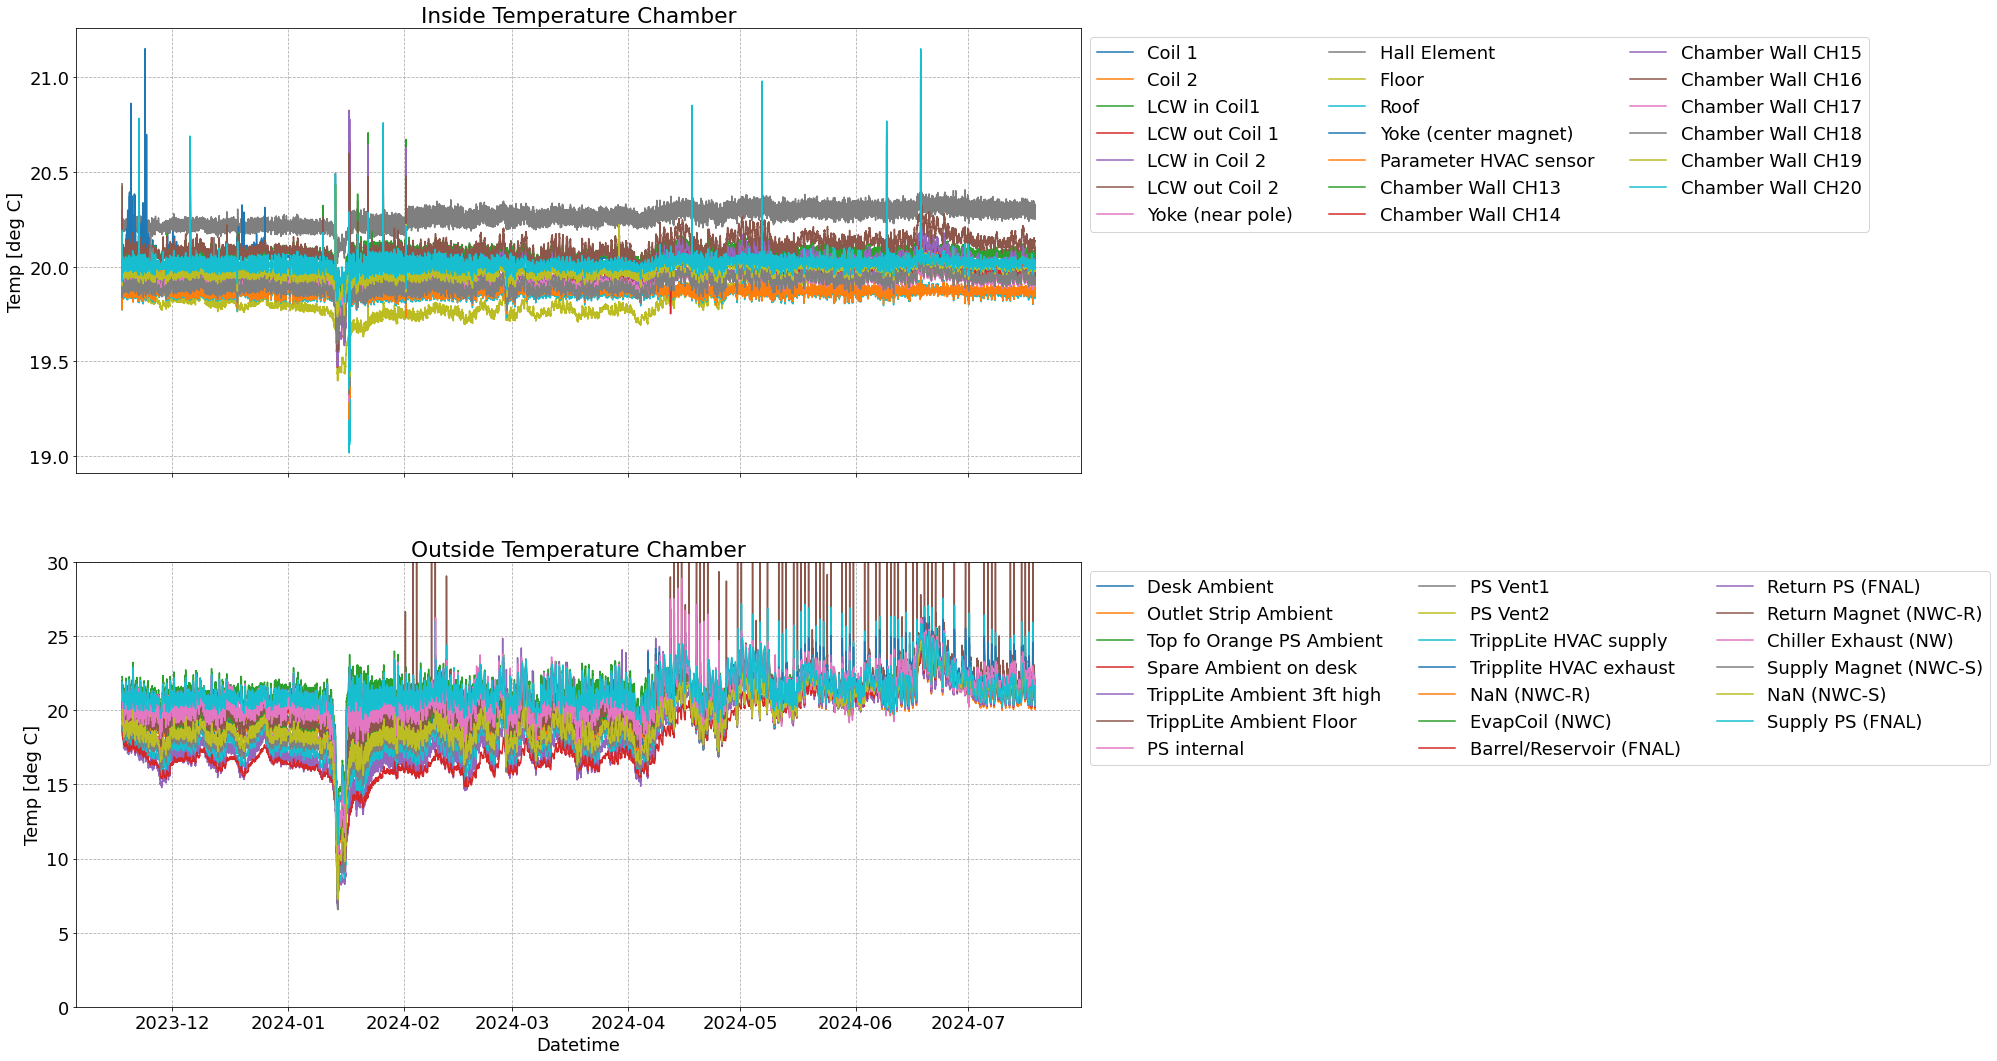

In [52]:
fig, axs = plt.subplots(2, 1, figsize=(18,18), sharex=True)

for c in temps_list[:20]:
    axs[0].plot(df_temp.index, df_temp[c], label=c)
    
for c in temps_list[20:]:
    axs[1].plot(df_temp.index, df_temp[c], label=c)
    
axs[0].set_title('Inside Temperature Chamber')
axs[1].set_title('Outside Temperature Chamber')

#axs[0].set_ylim([0, 30])
axs[1].set_ylim([0, 30])

axs[1].set_xlabel('Datetime')
axs[0].set_ylabel('Temp [deg C]')
axs[1].set_ylabel('Temp [deg C]')
axs[0].legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');
axs[1].legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

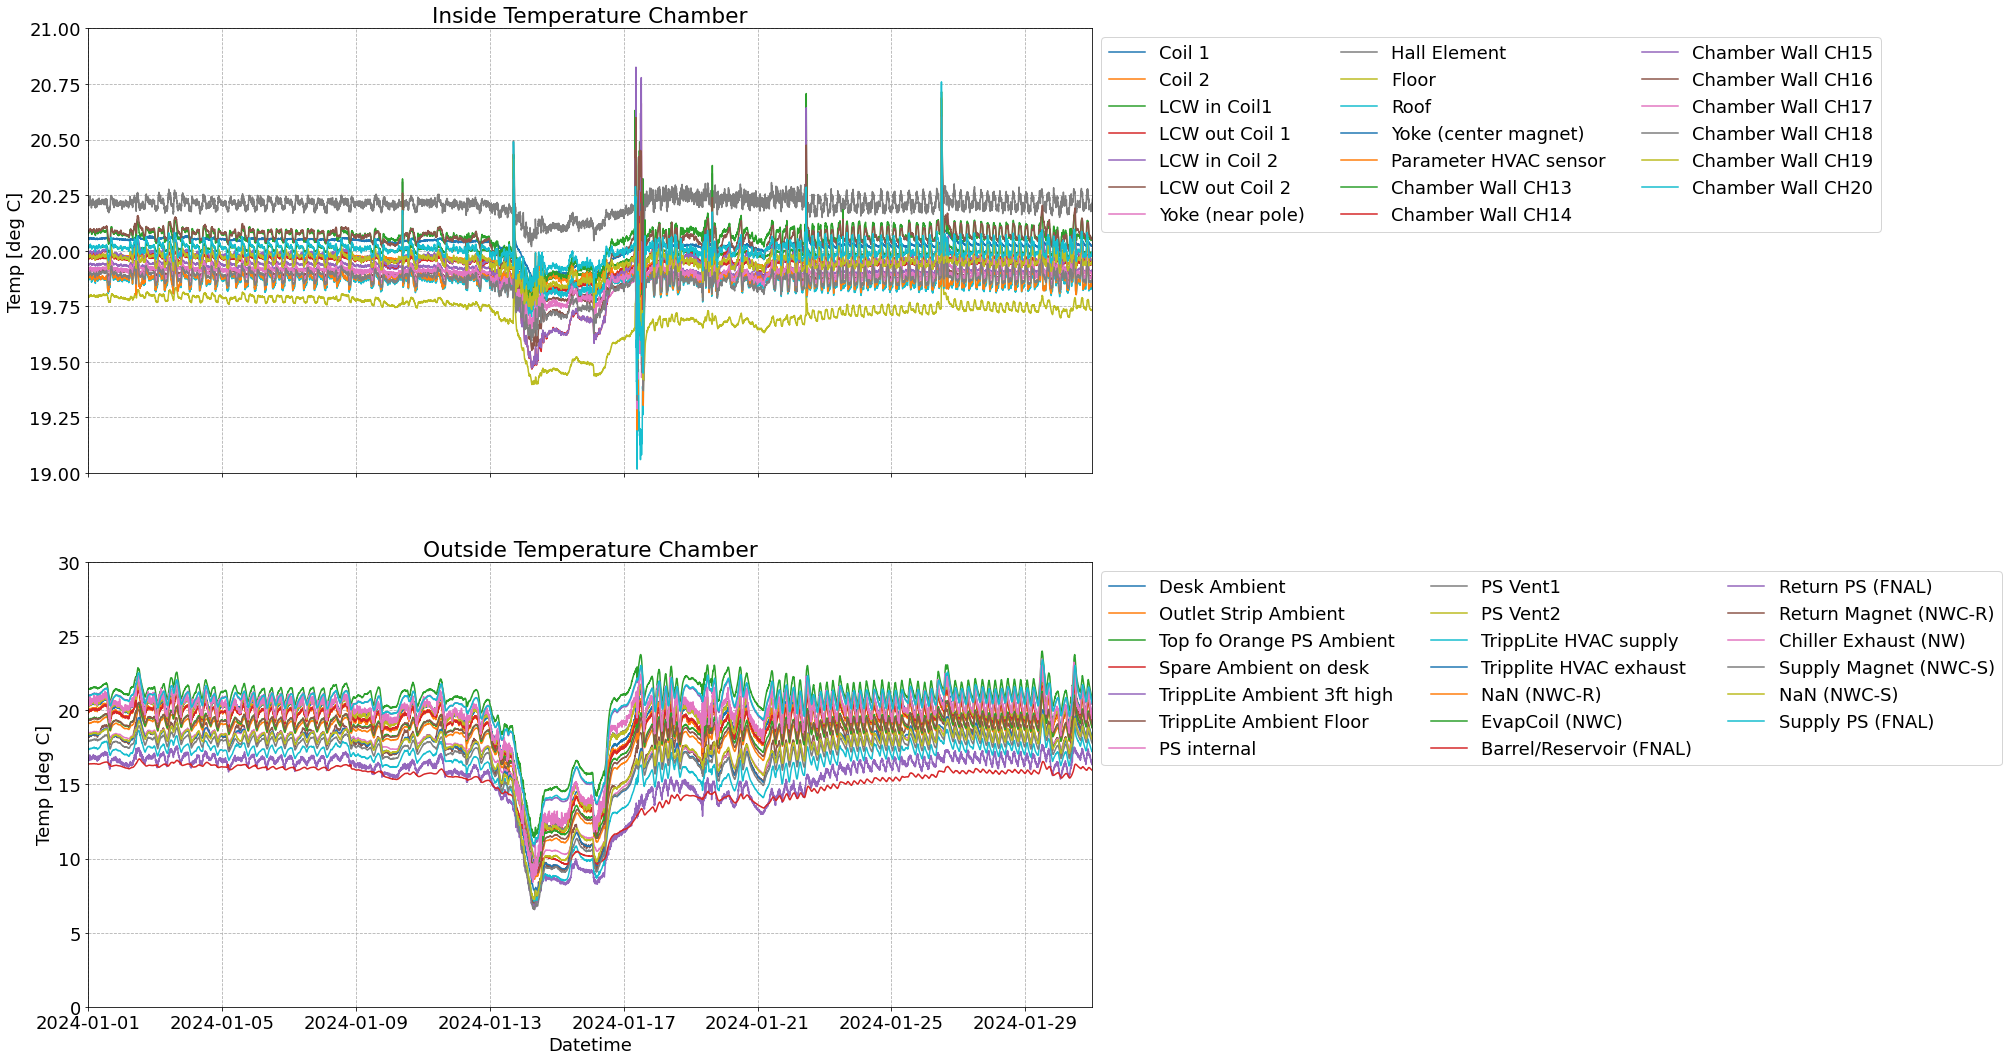

In [50]:
axs[0].set_xlim([datetime.strptime('2024-01-01 00:00', '%Y-%m-%d %H:%M'), datetime.strptime('2024-01-31 00:00', '%Y-%m-%d %H:%M')])
axs[1].set_xlim([datetime.strptime('2024-01-01 00:00', '%Y-%m-%d %H:%M'), datetime.strptime('2024-01-31 00:00', '%Y-%m-%d %H:%M')])
axs[0].set_ylim([19, 21])
fig

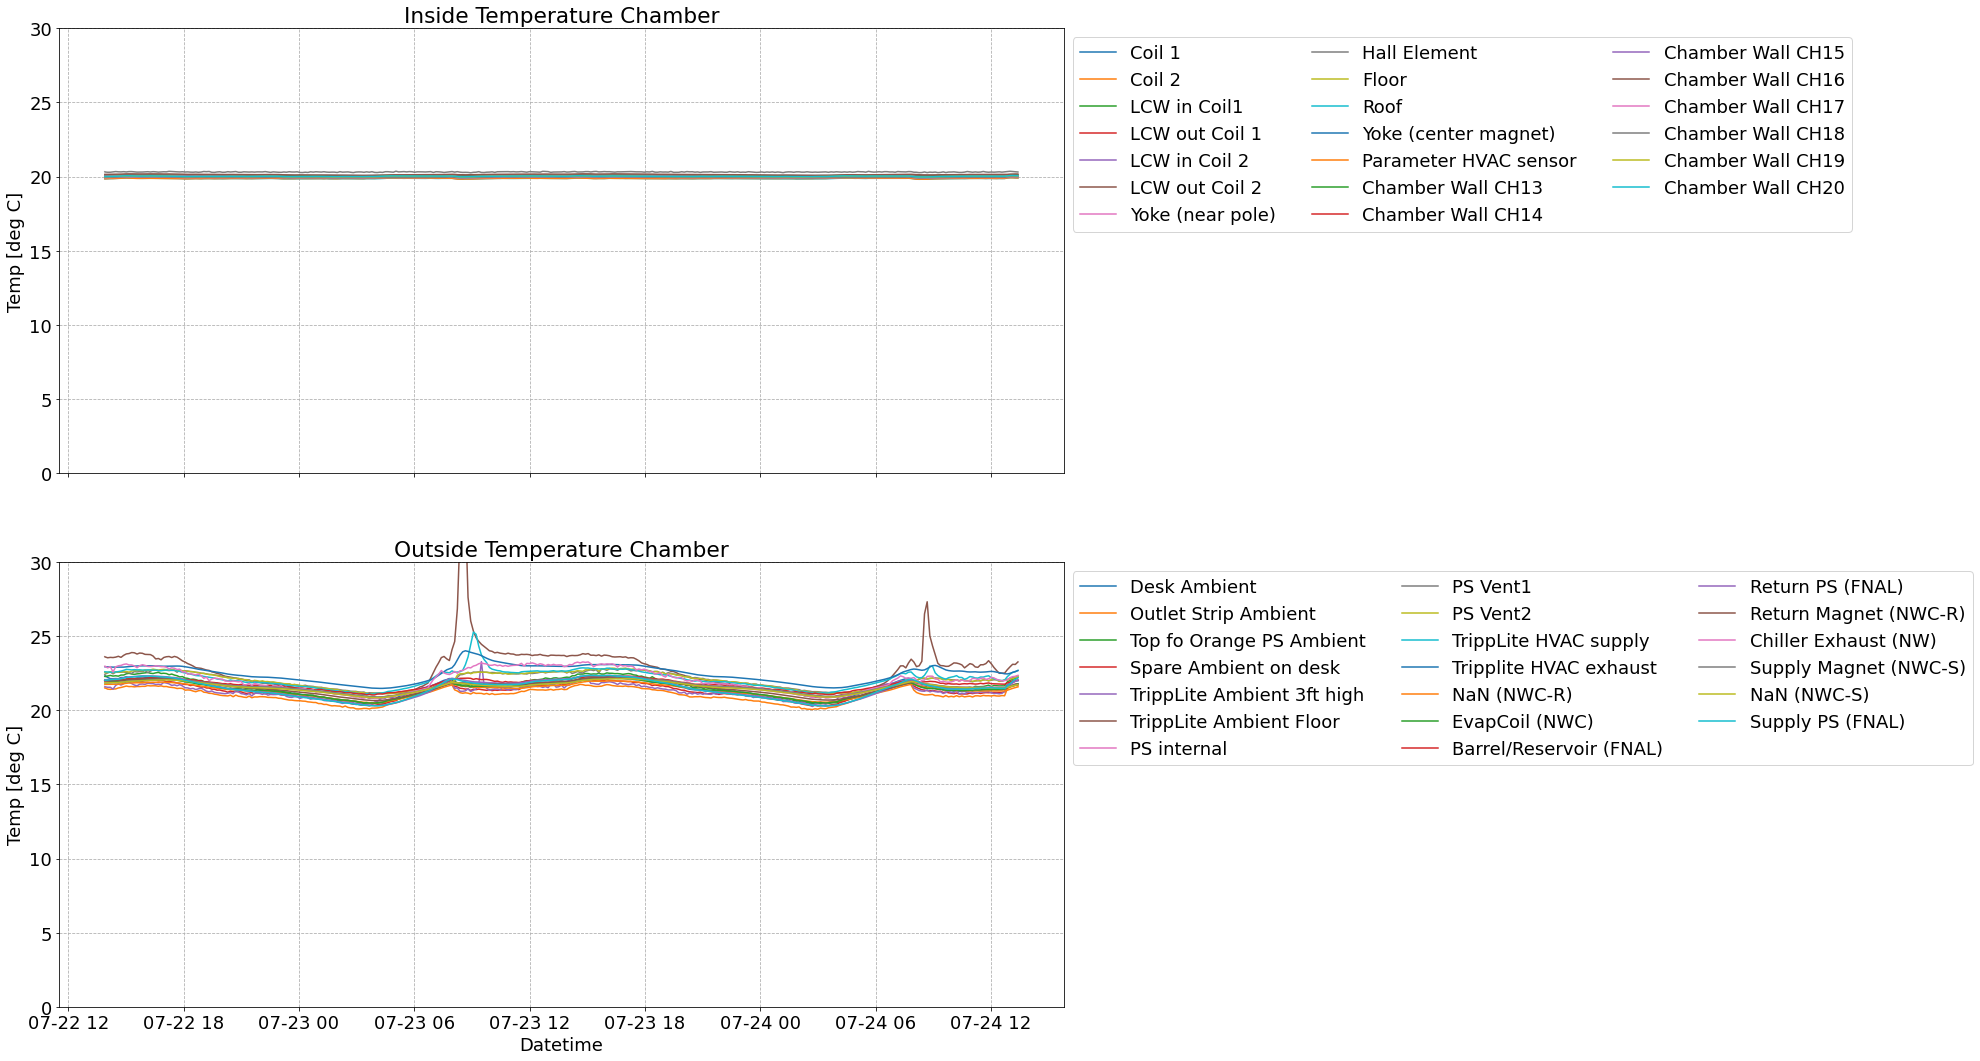

In [55]:
fig, axs = plt.subplots(2, 1, figsize=(18,18), sharex=True)

for c in temps_list[:20]:
    axs[0].plot(df_temp_new.index, df_temp_new[c], label=c)
    
for c in temps_list[20:]:
    axs[1].plot(df_temp_new.index, df_temp_new[c], label=c)
    
axs[0].set_title('Inside Temperature Chamber')
axs[1].set_title('Outside Temperature Chamber')

axs[0].set_ylim([0, 30])
axs[1].set_ylim([0, 30])

#axs[0].set_ylim([15, 30])
#axs[1].set_ylim([15, 30])

axs[1].set_xlabel('Datetime')
axs[0].set_ylabel('Temp [deg C]')
axs[1].set_ylabel('Temp [deg C]')
axs[0].legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');
axs[1].legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

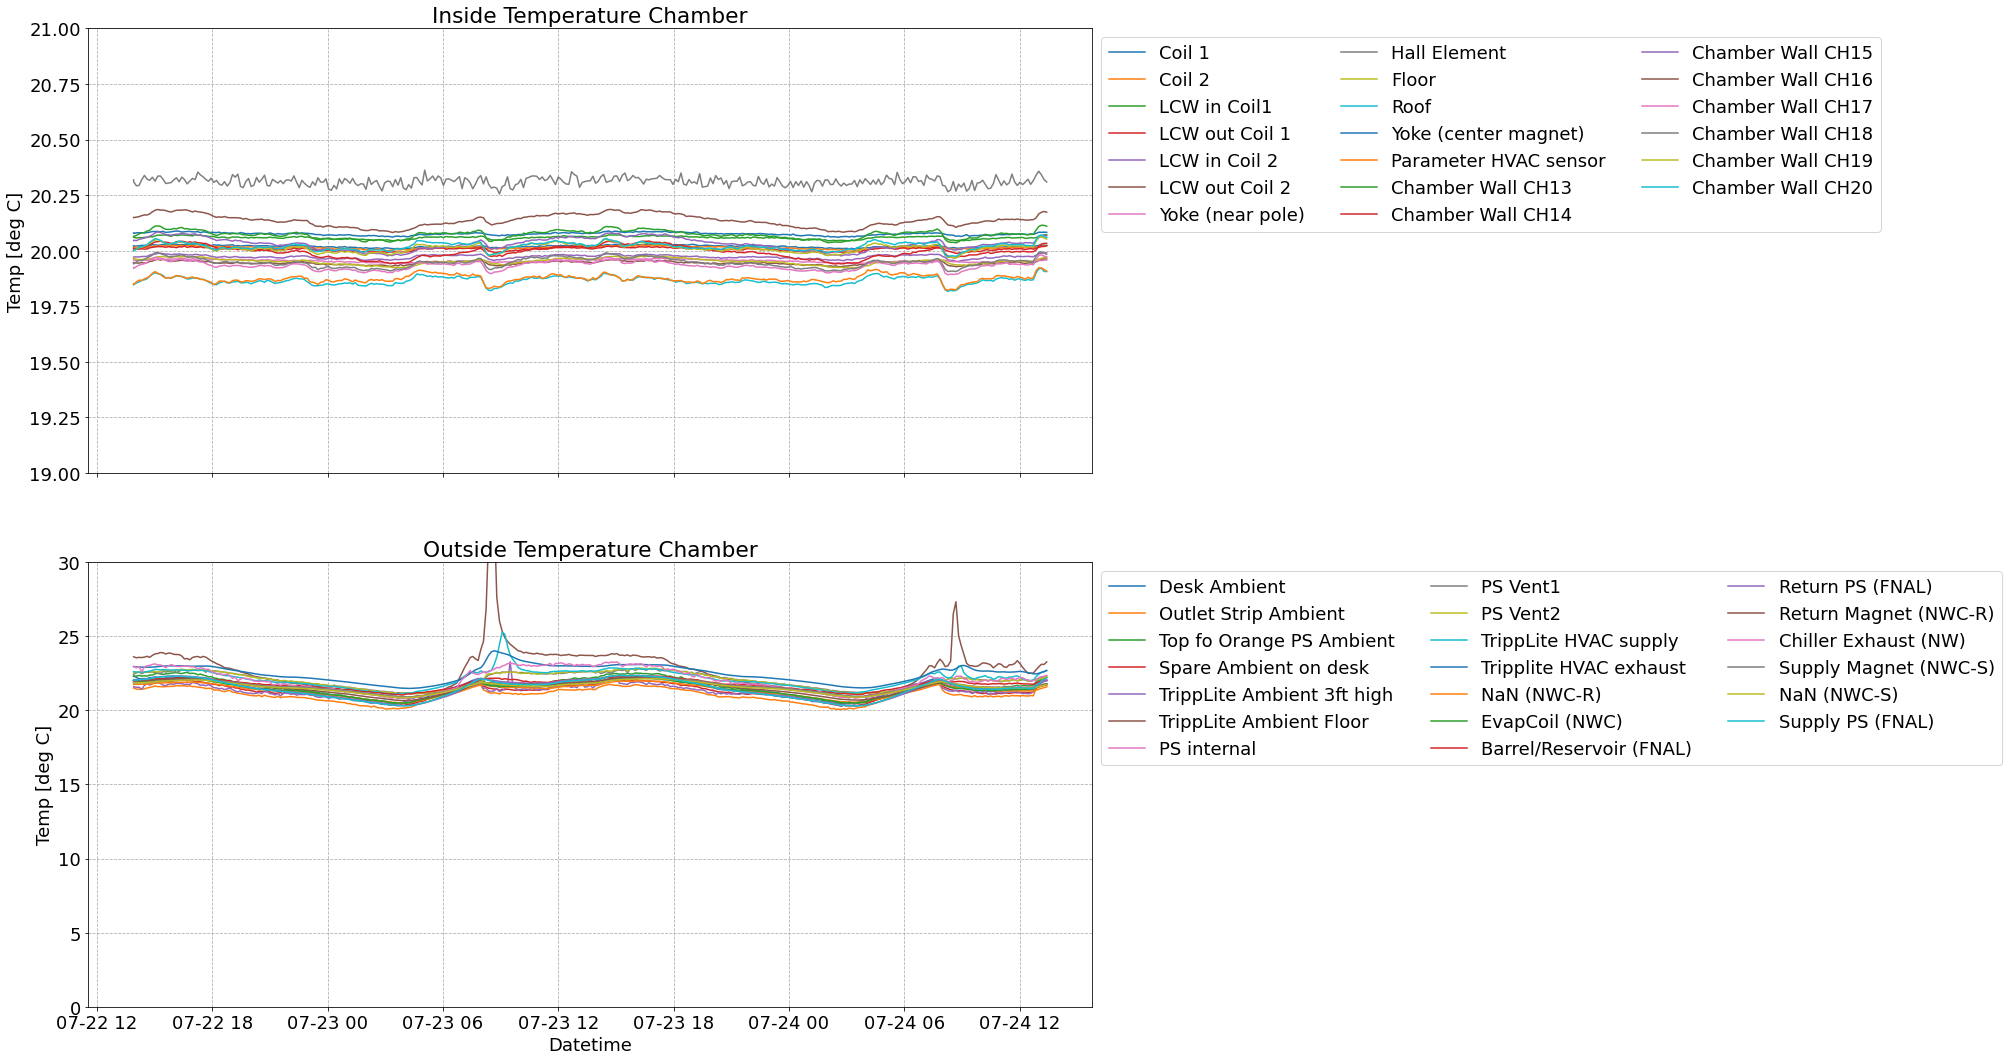

In [56]:
axs[0].set_ylim([19, 21])
fig

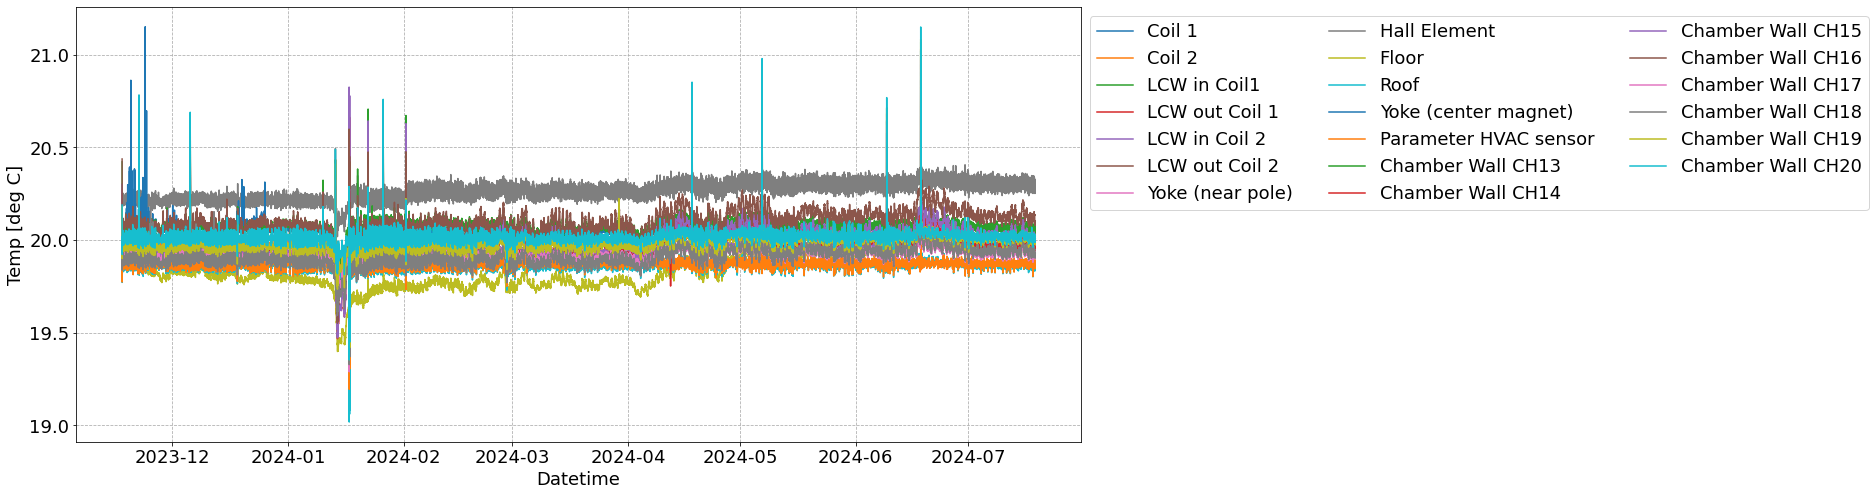

In [33]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[:20]:
    ax.plot(df_temp.index, df_temp[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

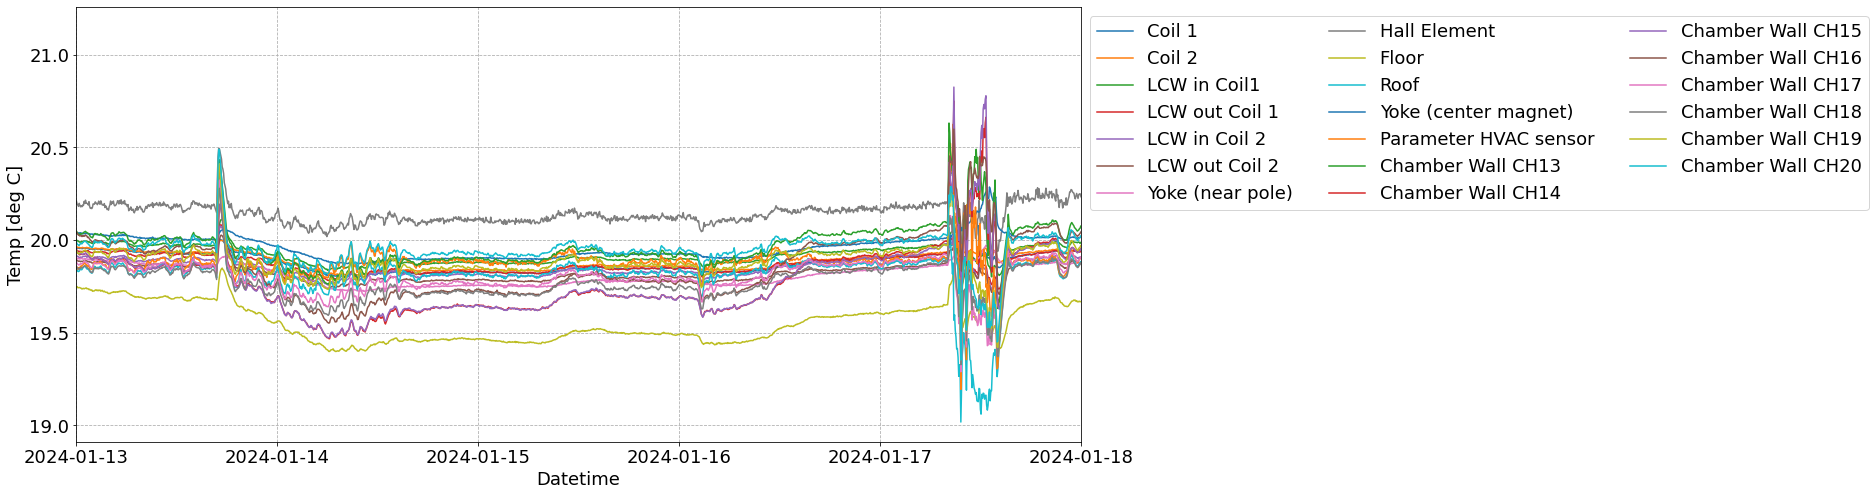

In [26]:
ax.set_xlim([datetime.strptime('2024-01-13 00:00', '%Y-%m-%d %H:%M'), datetime.strptime('2024-01-18 00:00', '%Y-%m-%d %H:%M')])
fig

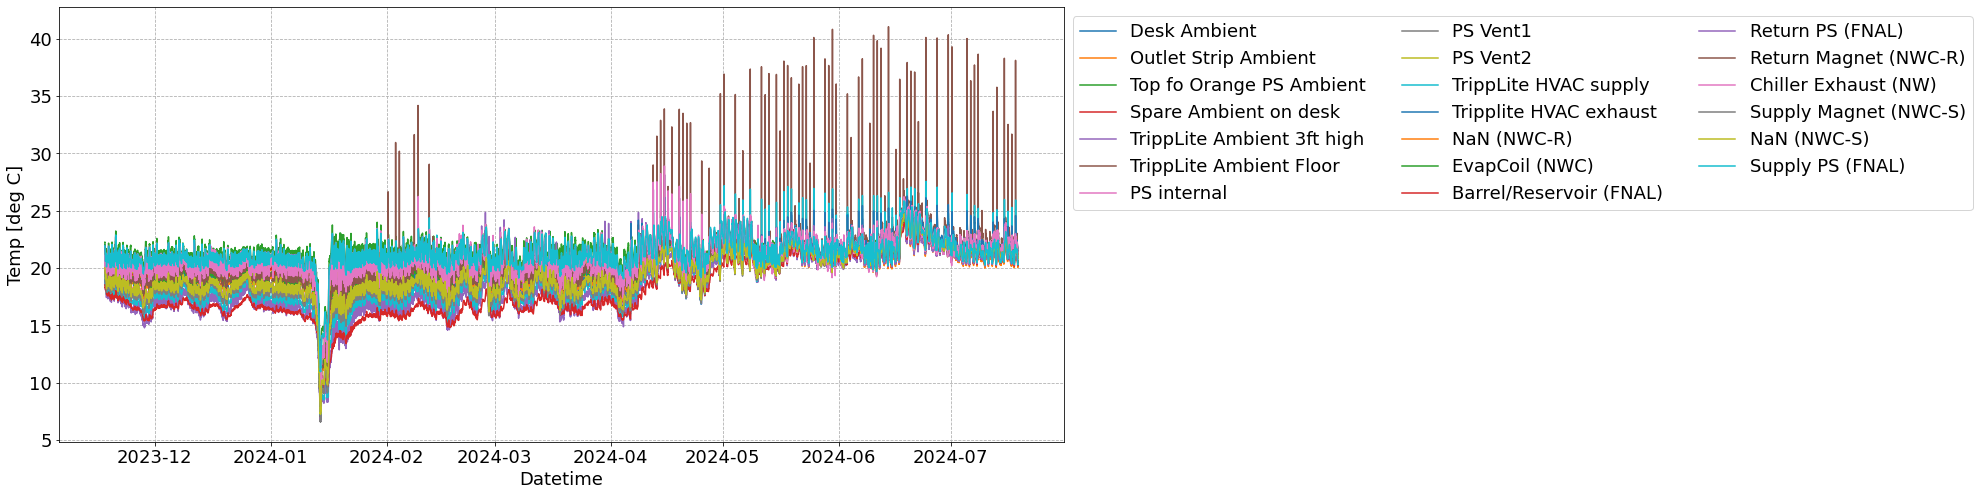

In [40]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[20:]:
    ax.plot(df_temp.index, df_temp[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');

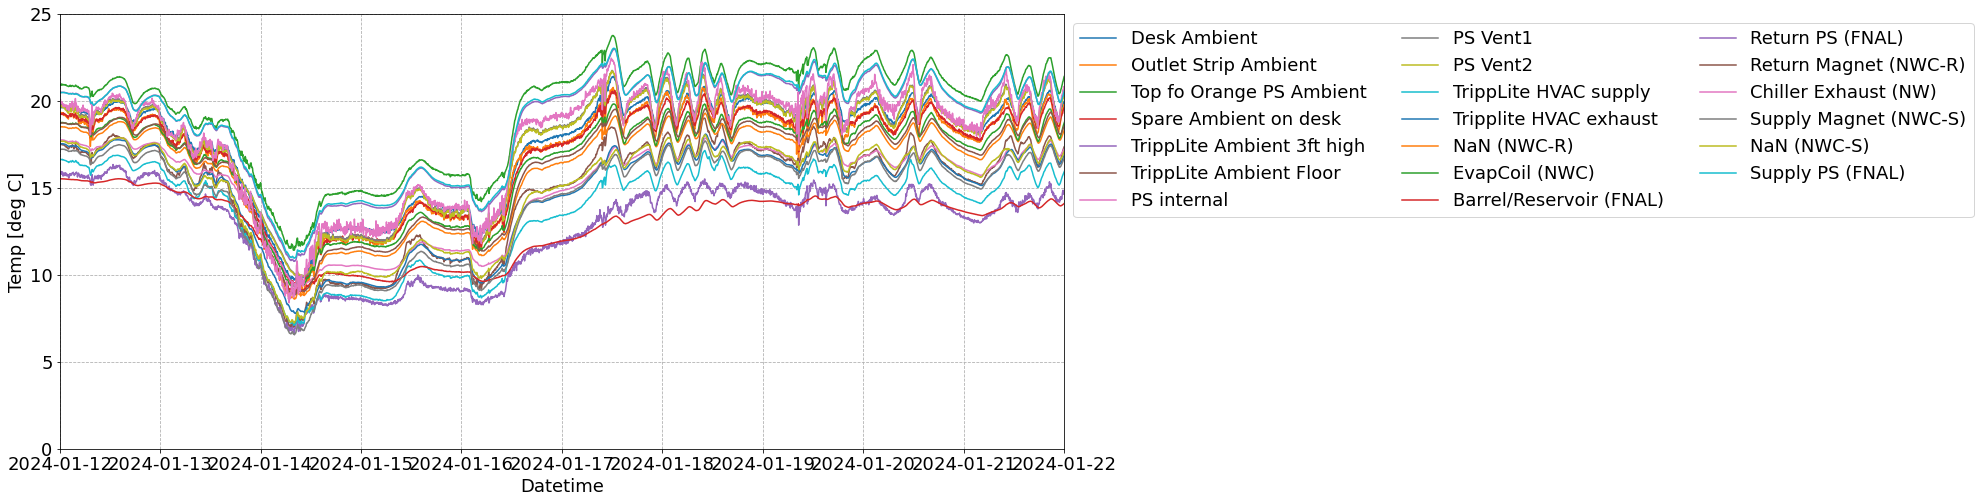

In [38]:
ax.set_xlim([datetime.strptime('2024-01-12 00:00', '%Y-%m-%d %H:%M'), datetime.strptime('2024-01-22 00:00', '%Y-%m-%d %H:%M')])
ax.set_ylim(0, 25)
fig

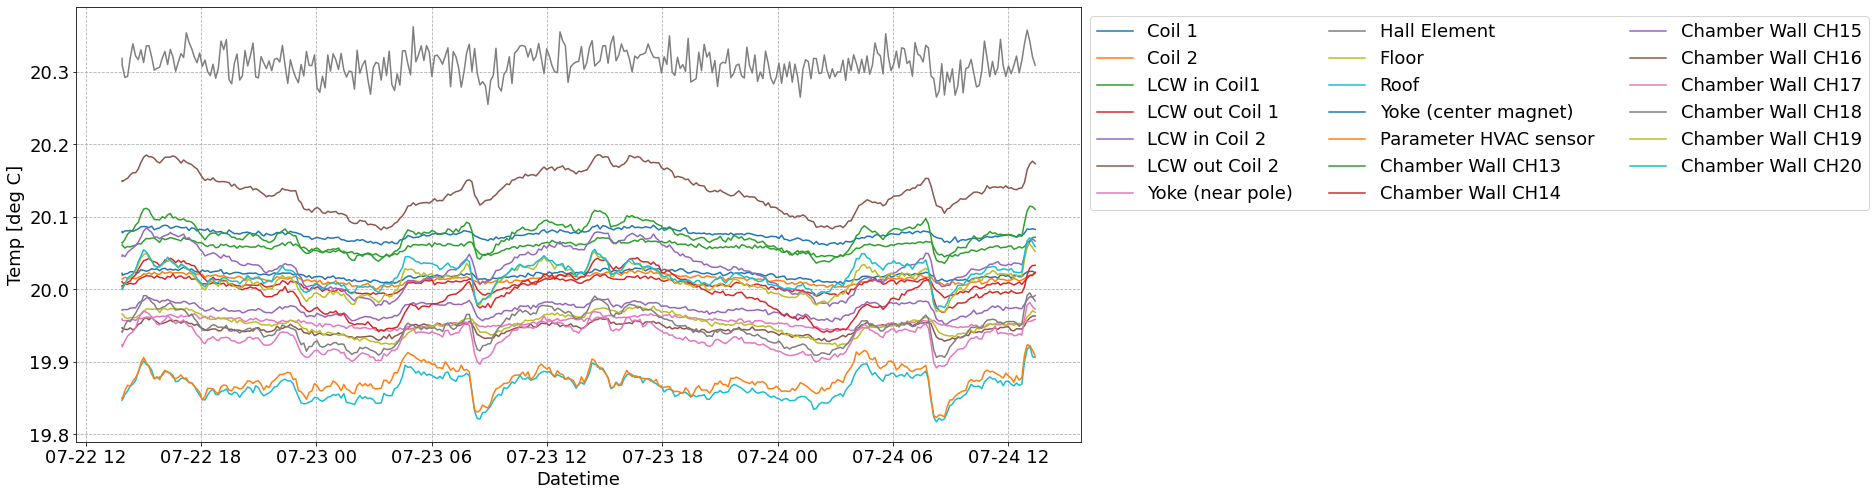

In [27]:
fig, ax = plt.subplots(figsize=(18, 8))

for c in temps_list[:20]:
    ax.plot(df_temp_new.index, df_temp_new[c], label=c)
    
ax.set_xlabel('Datetime')
ax.set_ylabel('Temp [deg C]')
ax.legend(ncol=3, bbox_to_anchor=(1., 1.), loc='upper left');